### Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time
import json
import math

# Spelling Correction Library
from symspellpy import SymSpell 

# Library to create a dictionary with word and its freq in the given text
from collections import Counter

# Library to handle expand contracted words based on the context.
import contractions




### Importing Data


In [ ]:
def data_import(file='train.json', max_length=200):
  with open(file, 'r') as f:
      split_data = json.load(f)

  query = []
  utterance = []

  for i in split_data:
      if len(i['interaction'])==0:
          q = i['final']['query']
          u = i['final']['utterance']
      else:
          q = i['interaction'][0]['query']
          u = i['interaction'][0]['utterance']
      
      if len(q)<=200:
        query.append(q)
        utterance.append(u)  
  
  return query, utterance


### Data Cleaning and Preprocessing

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([^A-z0-9 ])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = w.strip()

  # adding contractions
  w = contractions.fix(w)
    
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.

  w = '<start> ' + w + ' <end>'
  return w


def create_dataset(path, num_examples, show_example=False):
  lines = path
  word_pairs = []
  for l in lines:
    word =preprocess_sentence(l)
    word_pairs.append(word)
  #word_pairs = preprocess_sentence(lines)
  
  if show_example:
    print(word_pairs[0])
  return  word_pairs

#### Spell checker

In [ ]:
def creating_vocab(data_list):
  corpus = []
  for data in data_list:
    for sentence in data:
      tokens = sentence.split()
      corpus.extend(tokens)
  
  corpus = Counter(corpus)
  with open('dictionary.txt', 'w') as f:
    for k, v in corpus.items():
      f.write(f"{k} {v}\n")
    
def spell_checker(inputTerm, path = './dictionary.txt'):
  symspell = SymSpell()
  symspell.load_dictionary(path, term_index=0, count_index=1)
  maxEditDistance = 2
  # ignore_non_words = True means if a particular word is not present then
  # we'll return as is.
  correct_sent = []
  for i in inputTerm.split():
    if i.isalnum():
      suggestion = symspell.lookup_compound(i, maxEditDistance, ignore_non_words=True)
      suggestion = str(suggestion[0]).split(',')[0].strip()
    else:
      suggestion = i.strip()  
    correct_sent.append(suggestion)
  
  return " ".join(correct_sent)

### Tokenization and Word Embeddings

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='',oov_token="<unk>")
  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def glove_embeddings(GLOVE_DIR, GLOVE_FILE, EMBEDDING_DIM):
  embeddings_index = {}
  f = open(os.path.join(GLOVE_DIR, GLOVE_FILE))
  emb_matrix = []
  for line in f:
      values = line.split()
      word = " ".join(values[:-1*EMBEDDING_DIM])
      coefs = np.asarray(values[-1*EMBEDDING_DIM:], dtype='float32')      
      embeddings_index[word] = coefs
      emb_matrix.append(coefs)
  f.close()

  embeddings_index['<unk>'] = np.mean(emb_matrix, axis=0) 
  
  scale = 1/max(1., (len(emb_matrix[0]))/2.)
  limit = math.sqrt(3.0 * scale)
  embeddings_index['<start>'] = np.random.uniform(-limit, limit, size=(1,EMBEDDING_DIM))
  embeddings_index['<end>'] = np.random.uniform(-limit, limit, size=(1,EMBEDDING_DIM))

  print('Found %s word vectors.' % len(embeddings_index))

  return embeddings_index

def embedding_matrix(embeddings_index, EMBEDDING_DIM, word_index):
  embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
      else:
        embedding_matrix[i] = embeddings_index['<unk>'] 
        + np.random.rand(1,EMBEDDING_DIM)
  return embedding_matrix

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
def store_embedding(emb, filename='Embedding'):
  emb.tofile(f'{filename}.dat')
  with open(f'{filename}_shape_info.txt', 'w') as f:
    f.write(f"{str(emb.shape[0])} {str(emb.shape[1])}")

def retrieve_embedding(filename = 'Embedding'):
  with open(f'{filename}_shape_info.txt', 'r') as f:
    for i in f:
      shape = (int(i.split()[0]), int(i.split()[1]))

  emb_matrix = np.fromfile(f'{filename}.dat').reshape(shape)
  return emb_matrix


### Encoder-Decoder NMT Model with Attention 

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, emb_type='default', emb_mat=[]):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    if emb_type == 'glove':
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[emb_mat])
    else:
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, emb_type='default', emb_mat=[]):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units

    if emb_type == 'glove':
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[emb_mat])
    else:
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size) 
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

### Main Function 

In [ ]:
# Setting OS Path to data folder
os.chdir('../data/')

# Data Import
query, utterance = data_import('train.json')

# Variables
embedding_dim = 300
glove_file_name = 'glove.840B.300d.txt'
# We can use either glove.6B.50d.txt or glove.840B.300d.txt

# Calling data cleaning and processing function
print('---Data after preprocessing and cleaning---')
en = create_dataset(utterance, None, show_example=True)
sql = create_dataset(query, None, show_example=True)

# Creating a spell checker based on given data to correct the input at 
# inference time
creating_vocab([en, sql])
example_sent = 'what is the number ofeemployees in each department ?'
print(f'\nSpell Checker:\nBefore: {example_sent}')
print(f'After: {spell_checker(example_sent)} \n')

# Tokenization
targ_lang, inp_lang = sql, en
input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

# Extracting GloVe Embeddings
print('\n---Extracting Embedding Matrix---')
embeddings_index = glove_embeddings('./', glove_file_name, embedding_dim)

# Embedding Matrix
input_emb_matrix = embedding_matrix(embeddings_index, embedding_dim, inp_lang_tokenizer.word_index)
target_emb_matrix = embedding_matrix(embeddings_index, embedding_dim, targ_lang_tokenizer.word_index)

#storing embedding matrix
store_embedding(input_emb_matrix, 'input_emb_matrix')
store_embedding(target_emb_matrix, 'target_emb_matrix')

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print('\n---Data after Train-Test Split---')
print('Train-Input, Train-Target, Val-Input, Val-Target')
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

inp_lang = inp_lang_tokenizer
targ_lang = targ_lang_tokenizer

# Showing Mapping between words and indices
print ("\nInput Language; index to word mapping")
convert(inp_lang_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor_train[0])

---Data after preprocessing and cleaning---
<start> what is the number of employees in each department ? <end>
<start> select count ( departmentid ) from department group by departmentid <end>

Spell Checker:
Before: what is the number ofeemployees in each department ?
After: what is the number of employees in each department ? 


---Extracting Embedding Matrix---
Found 2195898 word vectors.

---Data after Train-Test Split---
Train-Input, Train-Target, Val-Input, Val-Target
2408 2408 603 603

Input Language; index to word mapping
2 ----> <start>
11 ----> show
15 ----> me
4 ----> the
579 ----> sales
16 ----> for
20 ----> each
94 ----> company
97 ----> !
3 ----> <end>

Target Language; index to word mapping
4 ----> <start>
2 ----> select
32 ----> id
19 ----> ,
1316 ----> sales_billion
3 ----> from
366 ----> companies
5 ----> <end>


In [ ]:
# Defining Variables for Modelling
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
embedding_dim = 300
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)

# Encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, 'glove', input_emb_matrix)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

# Attention Layer
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

# Decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'glove', target_emb_matrix)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))



(32, 28) (32, 51)
Encoder output shape: (batch size, sequence length, units) (32, 28, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)
Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 28, 1)
Decoder output shape: (batch_size, vocab size) (32, 1855)


### Optimizer and Loss Function

#### Loss Function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#### Creating checkpoints

In [ ]:
checkpoint_dir = '../training_checkpoints_glove_model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)

### Model Training

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1])) 

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

def val_step(inp, targ, enc_hidden):
  loss = 0

  enc_output, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

    loss += loss_function(targ[:, t], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1) 

  batch_loss = (loss / int(targ.shape[1])) 


  return batch_loss

In [ ]:
EPOCHS = 30
epoch_train_loss = []
epoch_val_loss = []


for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  total_loss_val = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

  for (batch, (inp, targ)) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss_val = val_step(inp, targ, enc_hidden)
    total_loss_val += batch_loss_val

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Train Loss {:.4f} Val Loss {:.4f}'.
        format(
            epoch + 1,
            total_loss / steps_per_epoch,
            total_loss_val / steps_per_epoch_val))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  epoch_train_loss.append(total_loss / steps_per_epoch)
  epoch_val_loss.append(total_loss_val / steps_per_epoch_val)

Epoch 1 Train Loss 0.8221 Val Loss 0.6182
Time taken for 1 epoch 78.93501782417297 sec

Epoch 2 Train Loss 0.5548 Val Loss 0.5099
Time taken for 1 epoch 28.299396991729736 sec

Epoch 3 Train Loss 0.4565 Val Loss 0.4560
Time taken for 1 epoch 27.30054759979248 sec

Epoch 4 Train Loss 0.3761 Val Loss 0.4078
Time taken for 1 epoch 28.605631828308105 sec

Epoch 5 Train Loss 0.3011 Val Loss 0.3663
Time taken for 1 epoch 27.758310079574585 sec

Epoch 6 Train Loss 0.2282 Val Loss 0.3293
Time taken for 1 epoch 28.66485023498535 sec

Epoch 7 Train Loss 0.1688 Val Loss 0.3120
Time taken for 1 epoch 27.627889156341553 sec

Epoch 8 Train Loss 0.1235 Val Loss 0.2952
Time taken for 1 epoch 28.97605538368225 sec

Epoch 9 Train Loss 0.0912 Val Loss 0.2958
Time taken for 1 epoch 27.655274629592896 sec

Epoch 10 Train Loss 0.0699 Val Loss 0.2951
Time taken for 1 epoch 28.87821650505066 sec

Epoch 11 Train Loss 0.0541 Val Loss 0.3024
Time taken for 1 epoch 27.739527702331543 sec

Epoch 12 Train Loss 0.04

### Loading Checkpoints

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


### Evaluation

In [ ]:
def evaluate(sentence, preprocess=False):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  if preprocess:
    sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = []

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()
    if targ_lang.index_word[predicted_id] == '<end>':
      return " ".join(result), sentence, attention_plot    

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result.append(targ_lang.index_word[predicted_id])

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return " ".join(result), sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1) 
  ax.matshow(attention, cmap='viridis')
  for (i, j), z in np.ndenumerate(attention):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [ ]:
def translate(sentence, plot=True, preprocess=False):
  result, sentence, attention_plot = evaluate(sentence, preprocess)

  if plot==True:
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  return result


In [ ]:
def jaccard_similarity(candidate, reference):
    """Returns the Jaccard similarity between two token lists

    Args:
        candidate (list of int): tokenized version of the candidate translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """
    
    # convert the lists to a set to get the unique tokens
    can_unigram_set, ref_unigram_set = set(candidate), set(reference)  
    
    # get the set of tokens common to both candidate and reference
    joint_elems = can_unigram_set.intersection(ref_unigram_set)
    
    # get the set of all tokens found in either candidate or reference
    all_elems = can_unigram_set.union(ref_unigram_set)
    
    # divide the number of joint elements by the number of all elements
    overlap = len(joint_elems) / len(all_elems)
    
    return overlap

In [ ]:
# for making a frequency table easily
from collections import Counter

def rouge1_similarity(system, reference):
    """Returns the ROUGE-1 score between two token lists

    Args:
        system (list of int): tokenized version of the system translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """        
    precision, recall, rougel_score = 0, 0, 0
    # make a frequency table of the system tokens
    sys_counter = Counter(system)
    
    # make a frequency table of the reference tokens
    ref_counter = Counter(reference)
    
    # initialize overlap to 0
    overlap = 0
    
    # run a for loop over the sys_counter object
    for token in sys_counter:
        
        # lookup the value of the token in the sys_counter dictionary
        token_count_sys = sys_counter.get(token,0)
        
        # lookup the value of the token in the ref_counter dictionary
        token_count_ref = ref_counter.get(token,0)
        
        # update the overlap by getting the smaller number between the two token counts above
        overlap += min(token_count_sys, token_count_ref)
    
    precision = overlap / sum(sys_counter.values())
    recall = overlap / sum(ref_counter.values())
    
    if precision + recall != 0:
        # compute the f1-score
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0 

    return precision, recall, rouge1_score

In [ ]:
def prediction(utterance_data, query_data):
  n = len(utterance_data)
  pred = []
  targets = []
  for i in range(n):
    actual = []
    target = []
    for j in utterance_data[i]:
      if j not in [0]:
        actual.append(inp_lang_tokenizer.index_word[j])
    
    actual = " ".join(actual)

    for j in query_data[i]:
      if j not in [0]:
        if targ_lang_tokenizer.index_word[j] not in ['<start>', '<end>']:
          target.append(targ_lang_tokenizer.index_word[j])
    
    targets.append(" ".join(target))  
    pred.append(translate(f"{actual}", plot=False))
  
  return pred, targets

def evaluation_metric(pred, target, method='jaccard'):
  scores = []
  precisions = []
  recalls = []
  n = len(pred)
  for i in range(n):
    if method == 'jaccard':
      score = jaccard_similarity(pred[i].split(), target[i].split())
    elif method == 'rougel':
      precision, recall, score = rouge1_similarity(pred[i].split(), target[i].split())
      precisions.append(precision)
      recalls.append(recall)
    elif method == 'bleu':
      score = bleu_score(pred[i].split(), target[i].split())
  
    scores.append(score)
  
  if method == 'rougel':
    return np.mean(scores), np.mean(precisions), np.mean(recalls)
  else:
    return np.mean(scores)

In [ ]:
pred_train, targets_train = prediction(input_tensor_train, target_tensor_train)
pred_val, targets_val = prediction(input_tensor_val, target_tensor_val)

In [ ]:
jaccard_score_train = evaluation_metric(pred_train, targets_train)

In [ ]:
precision_train, recall_train, rougel_score_train = evaluation_metric(pred_train, targets_train, method='rougel')

In [ ]:
jaccard_score_val = evaluation_metric(pred_val, targets_val)

In [ ]:
precision_val, recall_val, rougel_score_val = evaluation_metric(pred_val, targets_val, method='rougel')

In [ ]:
def metric_print(precision, recall, rougel_score, jaccard_similarity, text):
  print(f'---{text}---')
  print(f'Precision: {np.round(precision, 4)}')
  print(f'Recall: {np.round(recall, 4)}')
  print(f'Rougel Similarity Score: {np.round(rougel_score, 4)}')
  print(f'Jaccard Similarity: {np.round(jaccard_similarity, 4)}')
  print('\n')

In [ ]:
metric_print(precision_train, recall_train, rougel_score_train, jaccard_score_train, 'Evualtion Metrics on Training Dataset: ')
metric_print(precision_val, recall_val, rougel_score_val, jaccard_score_val, 'Evualtion Metrics on Validation Dataset: ')

---Evualtion Metrics on Training Dataset: ---
Precision: 0.975
Recall: 0.9784
Rougel Similarity Score: 0.9788
Jaccard Similarity: 0.9791


---Evualtion Metrics on Validation Dataset: ---
Precision: 0.7165
Recall: 0.7416
Rougel Similarity Score: 0.7492
Jaccard Similarity: 0.6641




#### Train and Validation Loss Plot

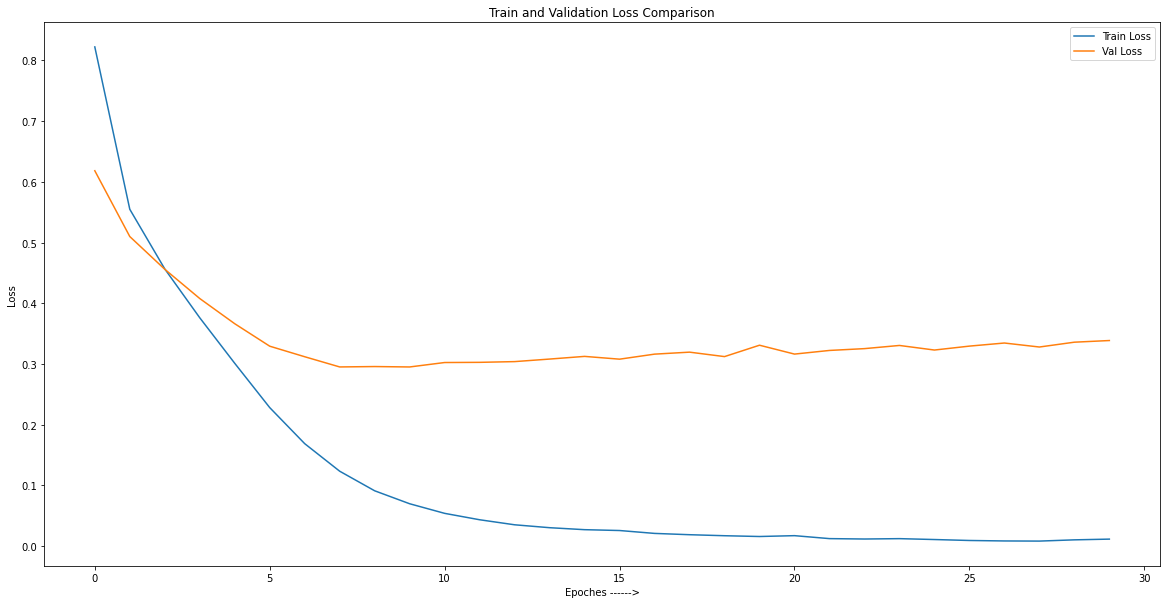

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.xlabel('Epoches ------>')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.title('Train and Validation Loss Comparison')
plt.show()


#### Real World Performance

Input: <start> how many students are there ? <end>
Predicted translation: select count ( * ) from student


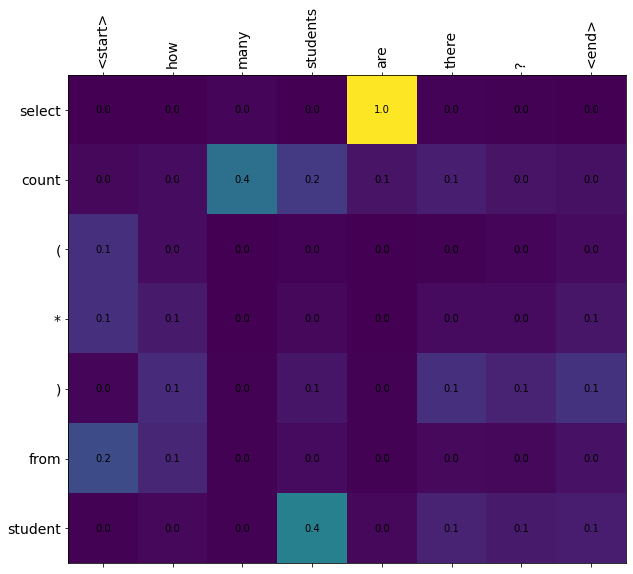

'select count ( * ) from student'

In [ ]:
translate("How many students are there?", preprocess=True)

Input: <start> what is the name of a student with minimum age ? <end>
Predicted translation: select t1 . cname from student where age = 20


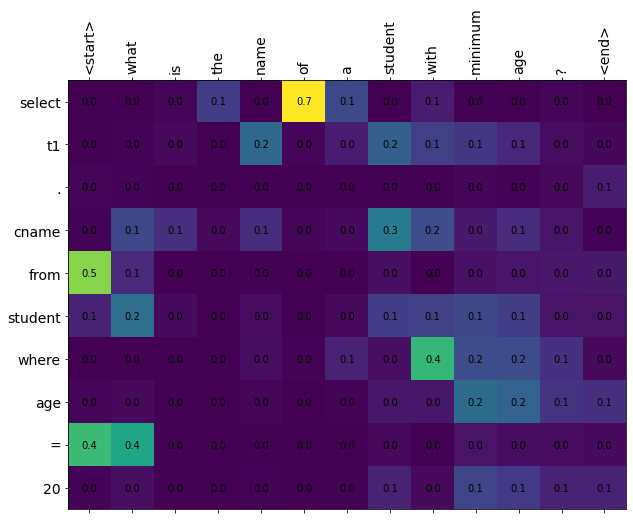

'select t1 . cname from student where age = 20'

In [ ]:
translate("What is the name of a student with minimum age?", preprocess=True)

Input: <start> what is the name of a student with minimum age ? <end>
Predicted translation: select t1 . cname from student where age = 20


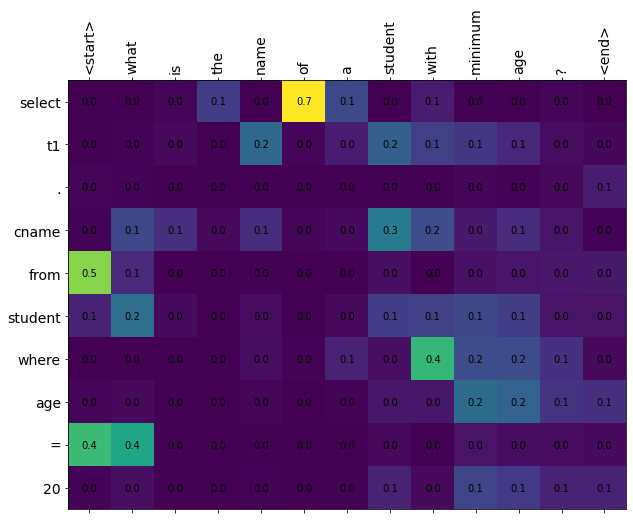

'select t1 . cname from student where age = 20'

In [ ]:
translate("What is the name of a student with minimum age?", preprocess=True)

In [ ]:
translate("Which student has the minimum age?", preprocess=True, plot=False)

'select min ( age ) from student where age = 1'

In [ ]:
translate(spell_checker("Tell me the name of all students"), preprocess=True, plot=False)

'select fname , fname , stuid from student'

In [ ]:
translate("What is the minimum age of a student?", preprocess=True, plot=False)

'select min ( age ) from student'

In [ ]:
translate(spell_checker("Tell me the name of all schools"), preprocess=True, plot=False)

'select t1 . school from school ;'

In [ ]:
translate(spell_checker("How many employees are there in each department?"), preprocess=True, plot=False)

'select count ( departmentid ) from department group by departmentid'

In [ ]:
# translate(spell_checker("Give me the names of all aircrafts"), preprocess=True, plot=False)